# Quantum Phase Estimation on a Grover Operator

This notebook demonstrates the capability of Classiq's QPE function, focusing on a case where it is applied on a Grover Operator. This is the core of the Amplitude Estimation algorithm.t

The demonstration done for a toy model, where the Grover operator is constructed for a "good state" on 5 qubits $|\psi\rangle_{\rm good}\propto (|2\rangle+|3\rangle+|5\rangle+|7\rangle+|11\rangle+|13\rangle$.

## 1. Building a model with Classiq

In [2]:
from classiq import ControlState, FunctionGenerator, FunctionLibrary, QReg, QUInt
from classiq.builtin_functions import HGate, Mcx, RYGate, UGate, XGate, ZGate

In [3]:
import numpy as np

NUM_QUBITS = 5
states_to_flip = [np.binary_repr(k, 4) for k in [2, 3, 5, 7, 11, 13]]
precisions = [l for l in range(1, 6)]
print("precisions:", precisions)

precisions: [1, 2, 3, 4, 5]


In [4]:
transpilation_options = {"classiq": "custom", "qiskit": 3}
# transpilation_options = {"classiq": "auto optimize", "qiskit": 1}

In [5]:
qmci_library = FunctionLibrary()

In [6]:
# Composite for specific state preparation

fg = FunctionGenerator(function_name="my_state_preparation")
wires_dict = fg.create_inputs({"io": QUInt[NUM_QUBITS]})

for state in states_to_flip:
    control_states = ControlState(ctrl_state=state, name="control")
    out = fg.XGate(
        params=XGate(),
        control_states=control_states,
        in_wires={
            "control": wires_dict["io"][0 : NUM_QUBITS - 1],
            "TARGET": wires_dict["io"][NUM_QUBITS - 1],
        },
    )
    wires_dict = {"io": QReg.concat(out["control"], out["TARGET"])}

fg.set_outputs(wires_dict)

qmci_library.add_function(fg.to_function_definition())

In [7]:
# Composite for good state oracle

fg = FunctionGenerator(function_name="my_oracle")

wires_dict = fg.create_inputs({"io": QUInt[NUM_QUBITS]})

out = fg.ZGate(ZGate(), in_wires={"TARGET": wires_dict["io"][NUM_QUBITS - 1]})
wires_dict = {"io": QReg.concat(wires_dict["io"][0 : NUM_QUBITS - 1], out["TARGET"])}

fg.set_outputs(wires_dict)

qmci_library.add_function(fg.to_function_definition())

In [8]:
# Composite for zero_oracle

function_generator = FunctionGenerator(function_name="zero_oracle")

input_dict = function_generator.create_inputs({"mcz_io": QUInt[NUM_QUBITS]})


x_out = function_generator.XGate(
    params=XGate(),
    in_wires={"TARGET": input_dict["mcz_io"][0]},
    should_control=False,
)
h_out = function_generator.HGate(
    params=HGate(),
    in_wires={"TARGET": x_out["TARGET"][0]},
    should_control=False,
)


mcx_out = function_generator.Mcx(
    params=Mcx(num_ctrl_qubits=NUM_QUBITS - 1, ctrl_state="0" * (NUM_QUBITS - 1)),
    in_wires={
        "TARGET_QUBIT": h_out["TARGET"],
        "CTRL_IN": input_dict["mcz_io"][1:NUM_QUBITS],
    },
)


h_out = function_generator.HGate(
    params=HGate(), in_wires={"TARGET": mcx_out["TARGET_QUBIT"]}, should_control=False
)
x_out = function_generator.XGate(
    params=XGate(), in_wires={"TARGET": h_out["TARGET"]}, should_control=False
)

function_generator.set_outputs(
    {"mcz_io": QReg.concat(x_out["TARGET"], mcx_out["CTRL_IN"])}
)

qmci_library.add_function(function_generator.to_function_definition())

In [9]:
function_generator = FunctionGenerator(function_name="my_grover")
function_generator.include_library(qmci_library)


in_wires = function_generator.create_inputs({"io": QUInt[NUM_QUBITS]})

oracle_out = function_generator.my_oracle(in_wires=in_wires)

sps_inverse_out = function_generator.my_state_preparation(
    in_wires={"io": oracle_out["io"]},
    is_inverse=True,
    should_control=False,
)

zero_oracle_out = function_generator.zero_oracle(
    in_wires={"mcz_io": sps_inverse_out["io"]}
)


sps_out = function_generator.my_state_preparation(
    in_wires={"io": zero_oracle_out["mcz_io"]},
    should_control=False,
)


global_phase_out = function_generator.UGate(
    UGate(theta=0, phi=0, lam=0, gam=np.pi), in_wires={"TARGET": sps_out["io"][0]}
)


function_generator.set_outputs(
    {"io": QReg.concat(sps_out["io"][1:NUM_QUBITS], global_phase_out["TARGET"])}
)


qmci_library.add_function(function_generator.to_function_definition())

In [10]:
from classiq.model import CustomHardwareSettings, Preferences

preferences = Preferences(
    custom_hardware_settings=CustomHardwareSettings(basis_gates=["cx", "u"]),
    transpilation_option=transpilation_options["classiq"],
)

### 1.1 Width Optimization

In [11]:
from classiq import (
    GeneratedCircuit,
    Model,
    set_constraints,
    set_preferences,
    synthesize,
)
from classiq.builtin_functions import PhaseEstimation
from classiq.model import Constraints, OptimizationParameter

classiq_depths_ae_opt_width = []
classiq_cx_counts_ae_opt_width = []
classiq_widths_ae_opt_width = []

constraints = Constraints(
    optimization_parameter=OptimizationParameter.WIDTH,
)


for precision in precisions:
    model = Model()
    model.include_library(qmci_library)

    qpe_out = model.PhaseEstimation(
        params=PhaseEstimation(
            size=precision,
            unitary_params=qmci_library.get_function("my_grover"),
            unitary="my_grover",
        ),
    )

    qmod = model.get_model()
    qmod = set_constraints(qmod, constraints=constraints)
    qmod = set_preferences(qmod, preferences=preferences)
    quantum_program = synthesize(qmod)
    circuit = GeneratedCircuit.from_qprog(quantum_program)
    classiq_widths_ae_opt_width.append(circuit.data.width)
    classiq_depths_ae_opt_width.append(circuit.transpiled_circuit.depth)
    classiq_cx_counts_ae_opt_width.append(circuit.transpiled_circuit.count_ops["cx"])

print("classiq depths:", classiq_depths_ae_opt_width)
print("classiq cx_counts:", classiq_cx_counts_ae_opt_width)
print("classiq widths:", classiq_widths_ae_opt_width)

classiq depths: [870, 2606, 6078, 13022, 26910]
classiq cx_counts: [513, 1544, 3600, 7713, 15929]
classiq widths: [6, 7, 8, 9, 10]


### 1.3 Depth Optimization with a Constrained Width

In [12]:
classiq_cx_counts_ae_opt_depth_max_width = []
classiq_depths_ae_opt_depth_max_width = []
classiq_widths_ae_opt_depth_max_width = []


for precision in precisions:
    constraints = Constraints(
        optimization_parameter=OptimizationParameter.DEPTH,
        max_width=15 + 3 * (precision - 1),  # setting some bound
    )

    model = Model()
    model.include_library(qmci_library)

    qpe_out = model.PhaseEstimation(
        params=PhaseEstimation(
            size=precision,
            unitary_params=qmci_library.get_function("my_grover"),
            unitary="my_grover",
        ),
    )

    qmod = model.get_model()
    qmod = set_constraints(qmod, constraints=constraints)
    qmod = set_preferences(qmod, preferences=preferences)
    quantum_program = synthesize(qmod)
    circuit = GeneratedCircuit.from_qprog(quantum_program)
    classiq_widths_ae_opt_depth_max_width.append(circuit.data.width)
    classiq_depths_ae_opt_depth_max_width.append(circuit.transpiled_circuit.depth)
    classiq_cx_counts_ae_opt_depth_max_width.append(
        circuit.transpiled_circuit.count_ops["cx"]
    )

print("classiq depths:", classiq_depths_ae_opt_depth_max_width)
print("classiq cx_counts:", classiq_cx_counts_ae_opt_depth_max_width)
print("classiq widths:", classiq_widths_ae_opt_depth_max_width)

classiq depths: [418, 1247, 2902, 6213, 12873]
classiq cx_counts: [237, 713, 1663, 3560, 7369]
classiq widths: [15, 18, 21, 24, 27]


## 2. Comparing to Qiskit Implementation

In [13]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, transpile
from qiskit.circuit.library import GroverOperator, PhaseEstimation, XGate

# building the state preparation circuit, the last qubit is the indicator of good/bad state
state_preparation = QuantumCircuit(NUM_QUBITS)
for q in range(NUM_QUBITS - 1):
    state_preparation.h(q)

for states in states_to_flip:
    mcx = XGate().control(num_ctrl_qubits=NUM_QUBITS - 1, ctrl_state=states)
    state_preparation.append(mcx, [k for k in range(NUM_QUBITS)])

circuit = QuantumCircuit(NUM_QUBITS)
circuit.compose(state_preparation, [k for k in range(NUM_QUBITS)], inplace=True)

# building oracle
oracle = QuantumCircuit(NUM_QUBITS)
oracle.z(4)  # good state = last qubit is |1>

# building the grover operator
grover_op = GroverOperator(oracle, state_preparation=circuit, insert_barriers=True)


qiskit_depths_ae = []
qiskit_cx_counts_ae = []
qiskit_widths_ae = []
for precision in precisions:
    qpe_qc = PhaseEstimation(precision, circuit)
    transpiled_cir = transpile(
        qpe_qc,
        basis_gates=["u", "cx"],
        optimization_level=transpilation_options["qiskit"],
    )
    qiskit_depths_ae.append(transpiled_cir.depth())
    qiskit_cx_counts_ae.append(transpiled_cir.count_ops()["cx"])
    qiskit_widths_ae.append(transpiled_cir.width())

In [14]:
print("qiskit depths:", qiskit_depths_ae)
print("qiskit cx_counts:", qiskit_cx_counts_ae)
print("qiskit widths:", qiskit_widths_ae)

qiskit depths: [3220, 9638, 22470, 48122, 99414]
qiskit cx_counts: [1712, 5130, 11958, 25604, 52884]
qiskit widths: [6, 7, 8, 9, 10]


## 3. Plotting the Data

Text(4.8, 500.0, '(b)')

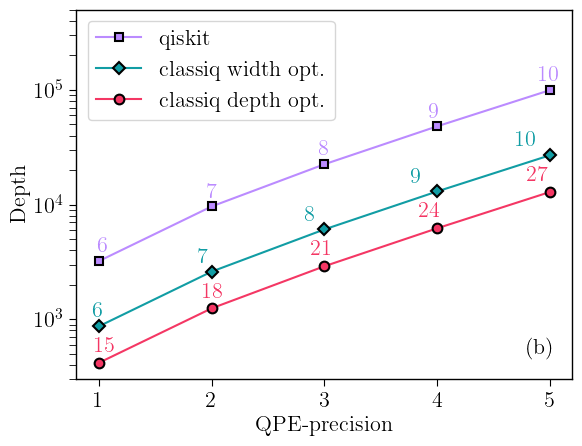

In [15]:
import matplotlib.pyplot as plt

classiq_color = "#119DA4"
classiq_color_1 = "#F43764"
qiskit_color = "#bb8bff"
plt.rc("text", usetex=True)
plt.rcParams["font.family"] = "serif"
plt.rc("savefig", dpi=300)
plt.rcParams["axes.linewidth"] = 1
plt.rcParams["xtick.major.size"] = 5
plt.rcParams["xtick.minor.size"] = 5
plt.rcParams["ytick.major.size"] = 5
plt.rcParams["ytick.minor.size"] = 5

(qiskit1,) = plt.semilogy(
    precisions,
    qiskit_depths_ae,
    "-s",
    label="qiskit",
    markerfacecolor=qiskit_color,
    markeredgecolor="k",
    markersize=6,
    markeredgewidth=1.5,
    color=qiskit_color,
)

(classiq1,) = plt.semilogy(
    precisions,
    classiq_depths_ae_opt_width,
    "-D",
    label="classiq width opt.",
    markerfacecolor=classiq_color,
    markeredgecolor="k",
    markersize=6.5,
    markeredgewidth=1.5,
    color=classiq_color,
)

(classiq2,) = plt.semilogy(
    precisions,
    classiq_depths_ae_opt_depth_max_width,
    "-o",
    label="classiq depth opt.",
    markerfacecolor=classiq_color_1,
    markeredgecolor="k",
    markersize=7,
    markeredgewidth=1.5,
    linewidth=1.5,
    color=classiq_color_1,
)


first_legend = plt.legend(
    handles=[qiskit1, classiq1, classiq2], fontsize=16, loc="upper left"
)


plt.ylabel("Depth", fontsize=16)
plt.xlabel("QPE-precision", fontsize=16)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.axis(ymin=3e2, ymax=5e5)
plt.xticks(precisions)


for x, y, num_qubits in zip(
    precisions, classiq_depths_ae_opt_width, classiq_widths_ae_opt_width
):
    plt.text(x * 0.94, y * 1.2, str(num_qubits), fontsize=16, color=classiq_color)
for x, y, num_qubits in zip(
    precisions,
    classiq_depths_ae_opt_depth_max_width,
    classiq_widths_ae_opt_depth_max_width,
):
    plt.text(x * 0.96, y * 1.25, str(num_qubits), fontsize=16, color=classiq_color_1)
for x, y, num_qubits in zip(precisions, qiskit_depths_ae, qiskit_widths_ae):
    plt.text(x * 0.98, y * 1.2, str(num_qubits), fontsize=16, color=qiskit_color)
plt.text(4.8, 5e2, "(b)", fontsize=16)